In [1]:
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from dotenv import load_dotenv
load_dotenv()

PROJECT_PATH = os.getenv('PROJECT_DIR')
sys.path.append(PROJECT_PATH)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# visualization
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
from src.data_ingestion.iex_data import IexDataFetcher
from src.data_ingestion.weather_data import WeatherDataFetcher
from src.feature_engineering.build_features import FeatureEngineering
from src.model_building.train_model import ModelTraining

from src.utils import *
from config.paths import *

In [3]:
# creating instances
iex_data = IexDataFetcher()
weather_data = WeatherDataFetcher()

featured_data = FeatureEngineering(PROJECT_PATH) 

In [4]:
dam = iex_data._get_processed_data('dam')
rtm = iex_data._get_processed_data('rtm')
# weather = weather_data._get_processed_weather('weather')
# wind = weather_data._get_processed_weather('wind')
# hydro = weather_data._get_processed_weather('hydro')
# solar = weather_data._get_processed_weather('solar')

dam data is already updated up to:  2024-01-14 23:45:00
rtm data updated up to:  14-01-2024 03:15


In [5]:
weather = load_pickle(processed_data_path, 'weather_data')
wind = load_pickle(processed_data_path, 'wind_data')
hydro = load_pickle(processed_data_path, 'hydro_data')
solar = load_pickle(processed_data_path, 'solar_data')

In [6]:
rtm = featured_data.shift_date(rtm, 1) 
weather = featured_data.shift_date(weather, -1)
hydro = featured_data.shift_date(hydro, -1) 
solar = featured_data.shift_date(solar, -1) 
wind = featured_data.shift_date(wind, -1)

data = featured_data.merge_dataframes([dam, rtm, weather, hydro, solar, wind])

In [7]:
data = featured_data._get_features(data, weather, data_type = 'dam')

In [8]:
def load_lightgbm_model(models_path):
    """
    Load LightGBM model and its best features.

    Args:
        model_path (str): Path to the directory containing model and feature files.

    Returns:
        tuple: Tuple containing the loaded model and best features.
    """
    best_features = load_pickle(models_path, 'dam_forecast').booster_.feature_name()
    model = load_pickle(models_path, 'dam_forecast')
    lower = load_pickle(models_path, 'dam_lower')
    upper = load_pickle(models_path, 'dam_upper')

    return best_features, model, lower, upper

In [10]:
def create_forecast(data, forecast_date, models_path):
    """
    Create forecast using a LightGBM model.

    Args:
        data (pd.DataFrame): Input DataFrame with necessary features.
        forecast_date (str): Date for which the forecast needs to be created (format: 'YYYY-MM-DD').
        model_path (str): Path to the directory containing the model files.

    Returns:
        pd.DataFrame: Forecasted values along with lower and upper bounds.
    """
    # Load the model and best features
    best_features, model, lower, upper = load_lightgbm_model(models_path)

    # Final DF
    features = ['datetime'] + best_features

    # Creating an empty dataframe
    data_for_training = data.reset_index()[features].copy()

    # Cutoff date for testing
    test_cutoff = datetime.strptime(forecast_date, '%Y-%m-%d') - timedelta(days=1)

    # Feature variables
    X = data_for_training.copy()

    # Dataframe for predictions
    X_test = X[(X['datetime'] >= test_cutoff) & (X['datetime'] < test_cutoff + timedelta(days=1))].iloc[:, 1:].copy()

    # Predict using the loaded model
    pred_test = model.predict(X_test)
    lower_pred = lower.predict(X_test)
    upper_pred = upper.predict(X_test)

    # Creating a DataFrame for forecasted values
    result = pd.DataFrame({
        'forecast': pred_test,
        'lower': lower_pred,
        'upper': upper_pred
    })

    # Round off the result
    result = np.round(result, 1)

    return result

In [11]:
def forecasting_date(df, market_type):
    """
    Calculate the next date for forecasting based on the last datetime in the DataFrame.

    Args:
        market_type (str): Market type identifier ('dam' or 'rtm').

    Returns:
        str: Forecasting date in 'YYYY-MM-DD' format.
    """
    # Find the last datetime in the DataFrame
    last_datetime = df['datetime'].max()

    # Determine the number of days to add based on the market type
    days_to_add = 1 if market_type.lower() == 'dam' else 2

    # Calculate the next date by adding days_to_add
    forecasting_date = (last_datetime + pd.DateOffset(days=days_to_add)).strftime('%Y-%m-%d')

    return forecasting_date

In [12]:
forecast_date = forecasting_date(data, 'dam')

In [19]:
forecast = create_forecast(data, forecast_date, models_path)

In [20]:
q = pd.DataFrame(pd.date_range(start = forecast_date, periods = 96, freq = '15min'), columns = ['datetime'])
forecast = pd.concat([q,forecast],axis = 1)

<Axes: xlabel='datetime'>

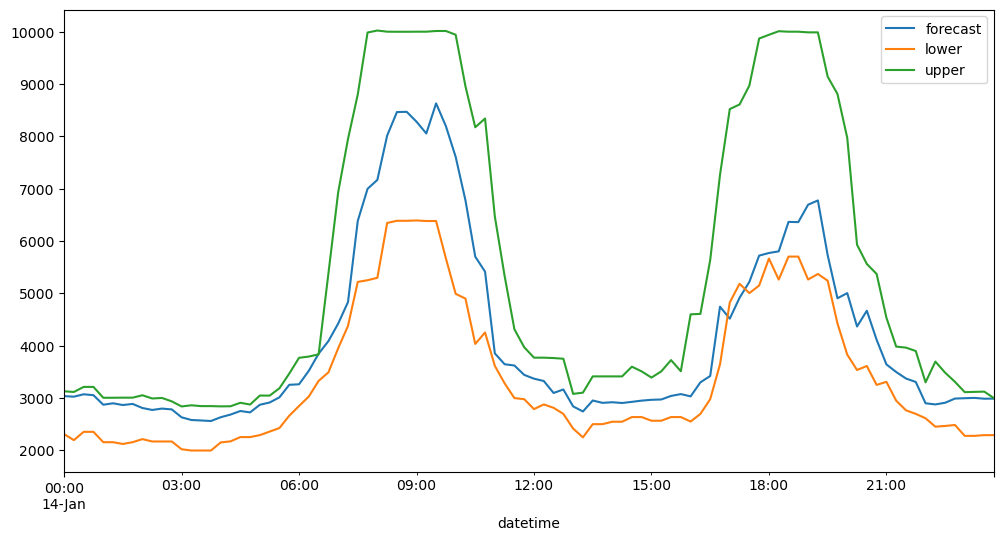

In [22]:
forecast.set_index('datetime').plot()